## General code

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import optimization
import evaluation
import pandas as pd
import strawberryfields as sf
import matplotlib.image as mpimg


# general stuff
state_dict = {(0, 0): '0', (np.pi, 0): '1', (np.pi/2, 0): '+'} # dictionary to save the date properly

def Vtanhgate(s): return sf.ops.Vgate(np.tanh(s))
def Kdl2c2gate(kappa): return sf.ops.Kdlcgate(kappa, 2, 2)
def Kdl6c2gate(kappa): return sf.ops.Kdlcgate(kappa, 6, 2)
def Kdl10c2gate(kappa): return sf.ops.Kdlcgate(kappa, 10, 2)

/Users/etiennestock/Documents/packages/strawberryfields/strawberryfields/apps/data/sample.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Discussion Kerr gate, driven Kerr gate with $\lambda =2$ and Cubic-Phase gate


- Driven Kerr hamiltonian
$$ 
\hat{H}_{\text{Kerr}} = - \frac{\chi}{2} {\hat{a}^{\dagger}}^2 \hat{a}^2 + \delta \hat{a}^\dagger \hat{a} + \beta ( \hat{a} + \hat{a}^\dagger )
$$

- Substitution 
$$
\hat{a} \mapsto \hat{a}_{\text{eff}} = \frac{\lambda \hat{x} + i \lambda^{-1}\hat{p}}{\sqrt{2}} + \alpha 
$$

- Driven Kerr hamiltonian under substitution
$$ 
\begin{aligned} 
\hat{H}_{\mathrm{Kerr}}^{\mathrm{eff}}(\delta, \beta)= 
& -\frac{\chi}{8}\left(\lambda^4 \hat{x}^4+\hat{p} \hat{x}^2 \hat{p}+\hat{x} \hat{p}^2 \hat{x}+\lambda^{-4} \hat{p}^4\right) \\ 
& -\frac{1}{\sqrt{2}} \chi \lambda^3 \alpha \hat{x}^3-\frac{1}{\sqrt{2}} \chi \lambda^{-1} \alpha \hat{p} \hat{x} \hat{p} \\ 
& +\frac{1}{2} \lambda^2\left(-3 \chi \alpha^2+\chi+\delta\right) \hat{x}^2 \\ & +\frac{1}{2} \lambda^{-2}\left(-\chi \alpha^2+\chi+\delta\right) \hat{p}^2 \\ 
& +\sqrt{2} \lambda\left(-\chi \alpha^3+\chi \alpha+\delta \alpha+\beta\right) \hat{x}
\end{aligned} 
$$

- Approximation
$$ 
\begin{aligned} 
\delta &= 3\chi\alpha^2 - \chi \\
\beta &= - 2\chi\alpha^3 \\
\alpha &\sim \lambda^3 
\end{aligned}
$$

- Approximation of the Cubic gate up to $\mathcal{O}(\lambda^{-1})$
$$
\hat{H}^{\text{cubic}}_{\text{Kerr}} = - \mu \hat{x}^3 
$$
with $ \mu = \frac{\chi\lambda^3}{\sqrt{2}} $

- Reinsert into driven Kerr gate: parameters
$$
\begin{aligned}
\alpha &= \lambda^3 \\
\chi &= 2 \\
\delta &= 6 \lambda^6 -2 \\
\beta &= -4 \lambda^9
\end{aligned}
$$

- hamiltonian
$$ 
\begin{aligned}
\hat{H}_{\text{Kerr}} &= - \frac{\chi}{2} \hat{n}^2 + \left( \frac{\chi}{2} + \delta \right) \hat{n} + \beta \left(\hat{a} + \hat{a}^\dagger \right)\\
&= - \frac{\chi}{2} \hat{n}^2 + \left( 5\lambda^6 - \frac{\chi}{2} \right) \hat{n} + -4 \lambda^9 \left(\hat{a} + \hat{a}^\dagger\right)
\end{aligned}
$$

In [3]:
# read in and store data
file_names = ['data_0_XRKd2S_60_025_15', 'data_0_XRKS_60_025_15', 'data_0_XRVtanhS_60_025_15']


# read in models
num_blocks = []
num_trials = []
opt        = np.empty(len(file_names), dtype=optimization.Optimization)
for i in range(len(file_names)): 
    opt[i]      = optimization.Optimization(file_name=file_names[i])
    num_blocks.append(opt[i].get_num_blocks())
    num_trials.append(opt[i].get_num_trials())


# check consistency of the read in data
delta = opt[0].get_delta()
if not all([delta == opt[i].get_delta() for i in range(1, len(file_names))]):
    raise ValueError('Try to compare data with different deltas!')

epsilon = opt[0].get_epsilon()
if not all([epsilon == opt[i].get_epsilon() for i in range(1, len(file_names))]):
    raise ValueError('Try to compare data with different epsilons!')

cutoff = opt[0].get_cutoff()
if not all([cutoff == opt[i].get_cutoff() for i in range(1, len(file_names))]):
    raise ValueError('Try to compare data with different cutoffs!')
    
state = opt[0].get_state()
if not all([state == opt[i].get_state() for i in range(1, len(file_names))]):
    raise ValueError('Try to compare data with different states!')
    

# read in data of models
Fids     = np.zeros((len(file_names), np.max(num_trials)), dtype=np.float32)
Sols     = np.zeros((len(file_names), np.max(num_trials), np.max(num_blocks)*5), dtype=np.float32)
bestFids = np.zeros(len(file_names), dtype=np.float32)

circuits  = []
gates     = []
rev_gates = []

for i in range(len(file_names)):
    Fids[i,:num_trials[i]] = opt[i].get_Fids()
    Sols[i,:num_trials[i],:num_blocks[i]*4] = opt[i].get_Sols()
    bestFids[i] = opt[i].get_bestFid()
    circuits.append(opt[i].get_circuit())
    gates.append(opt[i].get_gates())
    rev_gates.append(np.flip(opt[i].get_gates()))


# save to pandas results 
results = pd.DataFrame(data=np.array([circuits] + list([Fids[:,i] for i in range(np.max(num_trials))]) + list([bestFids])).T, columns=['method'] + [(f'{i+1}: ' + r'$\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$') for i in range(np.max(num_trials))] + [r'$\max_i\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$'])


In [4]:
# Prepare the target state in Fock basis, so that we can compare with our generated state
target_GKP = evaluation.prepare_GKP(epsilon=epsilon, cutoff=cutoff, state=state).ket()

# compute norm of the generated state to see the impact of the cutoff 
# and compute the fidelity between the generated and the target state
generated_GKP = np.empty((len(circuits), cutoff), dtype=np.complex64)
normgen       = np.empty(len(circuits), dtype=np.float32)
fid           = np.empty(len(circuits), dtype=np.float32)

for i in range(len(circuits)):    
    generated_GKP[i] = evaluation.prepare_state(rev_gates[i], -np.flip(opt[i].get_bestSol()), cutoff).ket()
    normgen[i]       = np.dot(generated_GKP[i].conj(), generated_GKP[i])
    fid[i]           = np.abs(np.dot(generated_GKP[i].conj(), target_GKP))**2


# Add results
results[r'$|\langle\Psi_g|\Psi_g\rangle|^2$'] = normgen
results[r'$|\langle\Psi_g|\Psi_t\rangle|^2$'] = fid


# calculate Glancy-Knill error
n    = 30 
size = 30 

results[r'$P_{\text{error}}$'] = np.empty(len(circuits), dtype=np.float32)

for i in range(len(circuits)): 
    results.loc[i, r'$P_{\text{error}}$'] = evaluation.error_gancy_knill(generated_GKP[i], n, size)

/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_50869/255600119.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_50869/255600119.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9775316513282488' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.


<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_50869/2402360986.py:17: SyntaxWarning: invalid escape sequence '\P'
/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_50869/2402360986.py:19: SyntaxWarning: invalid escape sequence '\s'


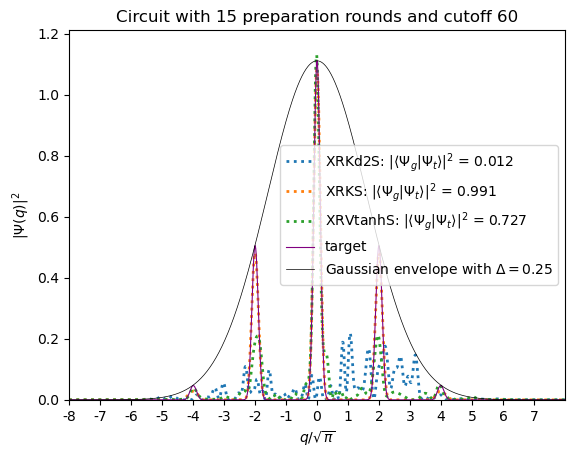

In [5]:
# Plot probability distribution of generated and target GKP states
qnum    = 8
qlim    = qnum*np.sqrt(np.pi) # q-axis goes from -qlim to +qlim
qvalues = np.linspace(-qlim,qlim, 1000)

targetGKPwf = evaluation.wavefunction(q=qvalues, ket=target_GKP)
gauss       = lambda x: np.max(np.abs(targetGKPwf*targetGKPwf.conj())) * np.exp(-x**2*(delta)**2)

genGKPwf    = np.empty((len(circuits), 1000), dtype=np.complex64)
for i in range(len(circuits)):
    genGKPwf[i] = evaluation.wavefunction(q=qvalues, ket=generated_GKP[i])
    plt.plot(qvalues, np.abs(genGKPwf[i]*genGKPwf[i].conj()), label=f'{circuits[i]}: '+r'$|\langle\Psi_g|\Psi_t\rangle|^2$'+f' = {fid[i]:.3f}', linestyle='dotted', linewidth=2)

plt.plot(qvalues, np.abs(targetGKPwf*targetGKPwf.conj()), label='target', color='purple', linewidth=0.8)
plt.plot(qvalues, gauss(qvalues), label=r'Gaussian envelope with $\Delta =$'+f'{delta}', color='black', linewidth=0.5)

plt.ylabel("$|\Psi(q)|^2$")
plt.xticks(np.sqrt(np.pi)*np.arange(-qnum, qnum), np.arange(-qnum, qnum))
plt.xlabel("$q/\sqrt{\pi}$")
plt.xlim(np.min(qvalues), np.max(qvalues))
plt.ylim(0, np.max(np.abs(targetGKPwf*targetGKPwf.conj()))+0.1)
plt.title(f'Circuit with {np.max(num_blocks)} preparation rounds and cutoff {cutoff}')
plt.legend()

plt.savefig(f'plots/plot_{cutoff}_{str(delta).replace(".", "")}_{np.max(num_blocks)}_' + '_'.join(str(c) for c in circuits) + '.png')
plt.show()

- $\lambda = 2$ as a measure for the approximation, we approximate in the cubic approximation $\frac{1}{\lambda}$ small
- driven Kerr circuit performs worse than the Kerr circuit and better than the regularised cubic phase circuit

# Discussion for different $\lambda = 2, 6, 10$ parameters 

In [6]:
img2 = mpimg.imread("plots/plot_60_025_15_XRKd2S.png")
img6 = mpimg.imread("plots/plot_60_025_15_XRKd6S.png")
img10 = mpimg.imread("plots/plot_60_025_15_XRKd10S.png")

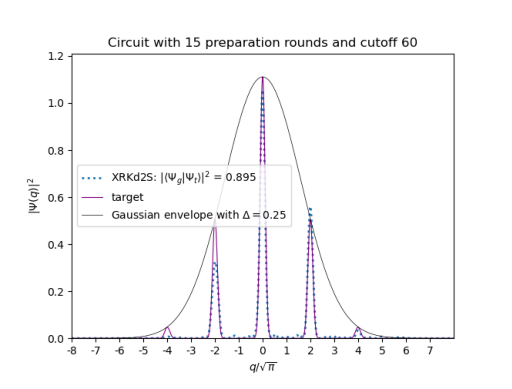

In [7]:
plt.axis('off')
plt.imshow(img2)
plt.show()

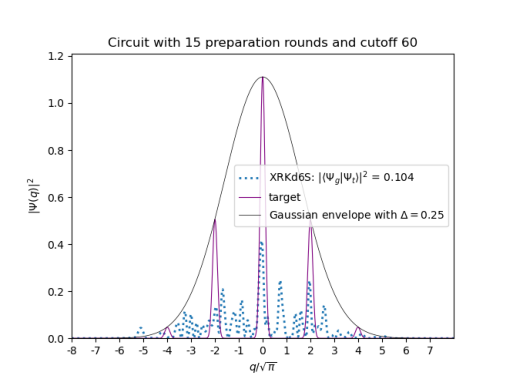

In [8]:
plt.axis('off')
plt.imshow(img6)
plt.show()

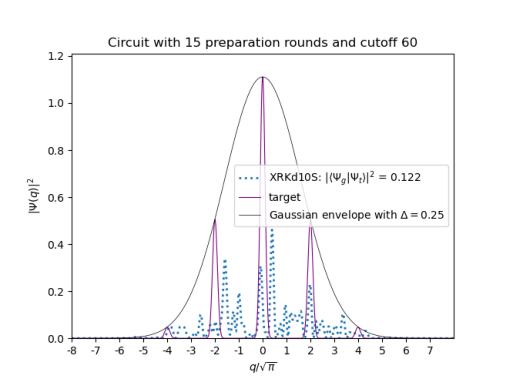

In [9]:
plt.axis('off')
plt.imshow(img10)
plt.show()

- decreasing performace while $\lambda$ increasing
- the bigger $\lambda$, the more dominant two last terms in $\hat{H}_{\text{Kerr}} = - \hat{n}^2 + \left( 5\lambda^6 - 1 \right) \hat{n} + -4 \lambda^9 \left(\hat{a} + \hat{a}^\dagger\right) $, the less the influence of the non-gaussian term, the worse the optimzation process (see different $\lambda$ fidelities)

# Discussion: Approximate Cubic gate with Kerr gate

Parameters
$$
\begin{aligned}
\alpha &= \lambda^3 \\
\chi &= 2 \\
\delta &= 6 \lambda^6 -2 \\
\beta &= -4 \lambda^9 \\
\mu &= \sqrt{2} \lambda^6
\end{aligned}
$$

Gates
$$
K(\kappa) = \exp\left( i\kappa \hat{H}_{\text{Kerr}}\right) \longrightarrow C(s) = \exp\left( i \frac{s}{3} \hat{x}^3\right) \stackrel{!}{\approx} \exp\left( i\kappa \hat{H}^{\text{Cubic}}_{\text{Kerr}} \right) = \exp \left( -i\kappa \mu \hat{x}^3 \right)
$$

$$
s = - 3 \kappa \mu 
$$

## Train batch with already existing parameters

In [28]:
# read in and store data
file_names = ['data_0_XRVtanhS_30_025_20']


# read in models
num_blocks = []
num_trials = []
opt        = np.empty(len(file_names), dtype=optimization.Optimization)
for i in range(len(file_names)): 
    opt[i]      = optimization.Optimization(file_name=file_names[i])
    num_blocks.append(opt[i].get_num_blocks())
    num_trials.append(opt[i].get_num_trials())


# check consistency of the read in data
delta = opt[0].get_delta()
if not all([delta == opt[i].get_delta() for i in range(1, len(file_names))]):
    raise ValueError('Try to compare data with different deltas!')

epsilon = opt[0].get_epsilon()
if not all([epsilon == opt[i].get_epsilon() for i in range(1, len(file_names))]):
    raise ValueError('Try to compare data with different epsilons!')

cutoff = opt[0].get_cutoff()
if not all([cutoff == opt[i].get_cutoff() for i in range(1, len(file_names))]):
    raise ValueError('Try to compare data with different cutoffs!')
    
state = opt[0].get_state()
if not all([state == opt[i].get_state() for i in range(1, len(file_names))]):
    raise ValueError('Try to compare data with different states!')
    

# read in data of models
Fids     = np.zeros((len(file_names), np.max(num_trials)), dtype=np.float32)
Sols     = np.zeros((len(file_names), np.max(num_trials), np.max(num_blocks)*5), dtype=np.float32)
bestFids = np.zeros(len(file_names), dtype=np.float32)

circuits  = []
gates     = []
rev_gates = []

for i in range(len(file_names)):
    Fids[i,:num_trials[i]] = opt[i].get_Fids()
    Sols[i,:num_trials[i],:num_blocks[i]*4] = opt[i].get_Sols()
    bestFids[i] = opt[i].get_bestFid()
    circuits.append(opt[i].get_circuit()[0])
    gates.append(opt[i].get_gates())
    rev_gates.append(np.flip(opt[i].get_gates()))

print(np.array([circuits]), 
               list([Fids[:,i] for i in range(np.max(num_trials))]), 
               np.array(list([bestFids])).T, 
      ['method'], [(f'{i+1}: ' + r'$\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$') for i in range(np.max(num_trials))]
          + [r'$\max_i\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$'])

# save to pandas results 
results = pd.DataFrame(data=np.array([circuits] + list([Fids[:,i] for i in range(np.max(num_trials))]) + list([bestFids])).T, columns=['method'] + [(f'{i+1}: ' + r'$\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$') for i in range(np.max(num_trials))] + [r'$\max_i\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$'])


[['XRVtanhS']] [array([0.9274182], dtype=float32)] [[0.9274182]] ['method'] ['1: $\\left|\\left<0\\right| U(\\vec{\\lambda})\\left|\\Psi_t \\right>\\right|^2$', '$\\max_i\\left|\\left<0\\right| U(\\vec{\\lambda})\\left|\\Psi_t \\right>\\right|^2$']


In [29]:
results

,method,1: $\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,$\max_i\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$
0,XRVtanhS,0.9274182,0.9274182
